In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from scipy import stats

# Dataset
data = pd.read_excel('D:\\Supply Chain Dataset\\DataCoSupplyChainDataset.xlsx')

def data_info(data):
    print('1) Number of columns are : ',data.shape[1])
    print('2) Number of rows are : ',data.shape[0])
    print('3) Total number of data-points :',data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes!='O']
    print('4) Count of Numerical Features :',len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes=='O']
    print('5) Count of Categorical Features :',len(cat_features))
data_info(data)


1) Number of columns are :  53
2) Number of rows are :  180519
3) Total number of data-points : 9567507
4) Count of Numerical Features : 31
5) Count of Categorical Features : 22


In [2]:
def features_with_missing_values(data):
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Total Missing Values is ' ,round(x,2) ,'%')
    print('Missing Value Estimation :')
    for i in data.columns:
        if data[i].isna().sum()>0:
            print('The Feature ',i,' has '+ str(data[i].isna().sum()) + ' missing values')
            
features_with_missing_values(data)



Percentage of Total Missing Values is  3.51 %
Missing Value Estimation :
The Feature  Customer Lname  has 8 missing values
The Feature  Customer Zipcode  has 3 missing values
The Feature  Order Zipcode  has 155679 missing values
The Feature  Product Description  has 180519 missing values


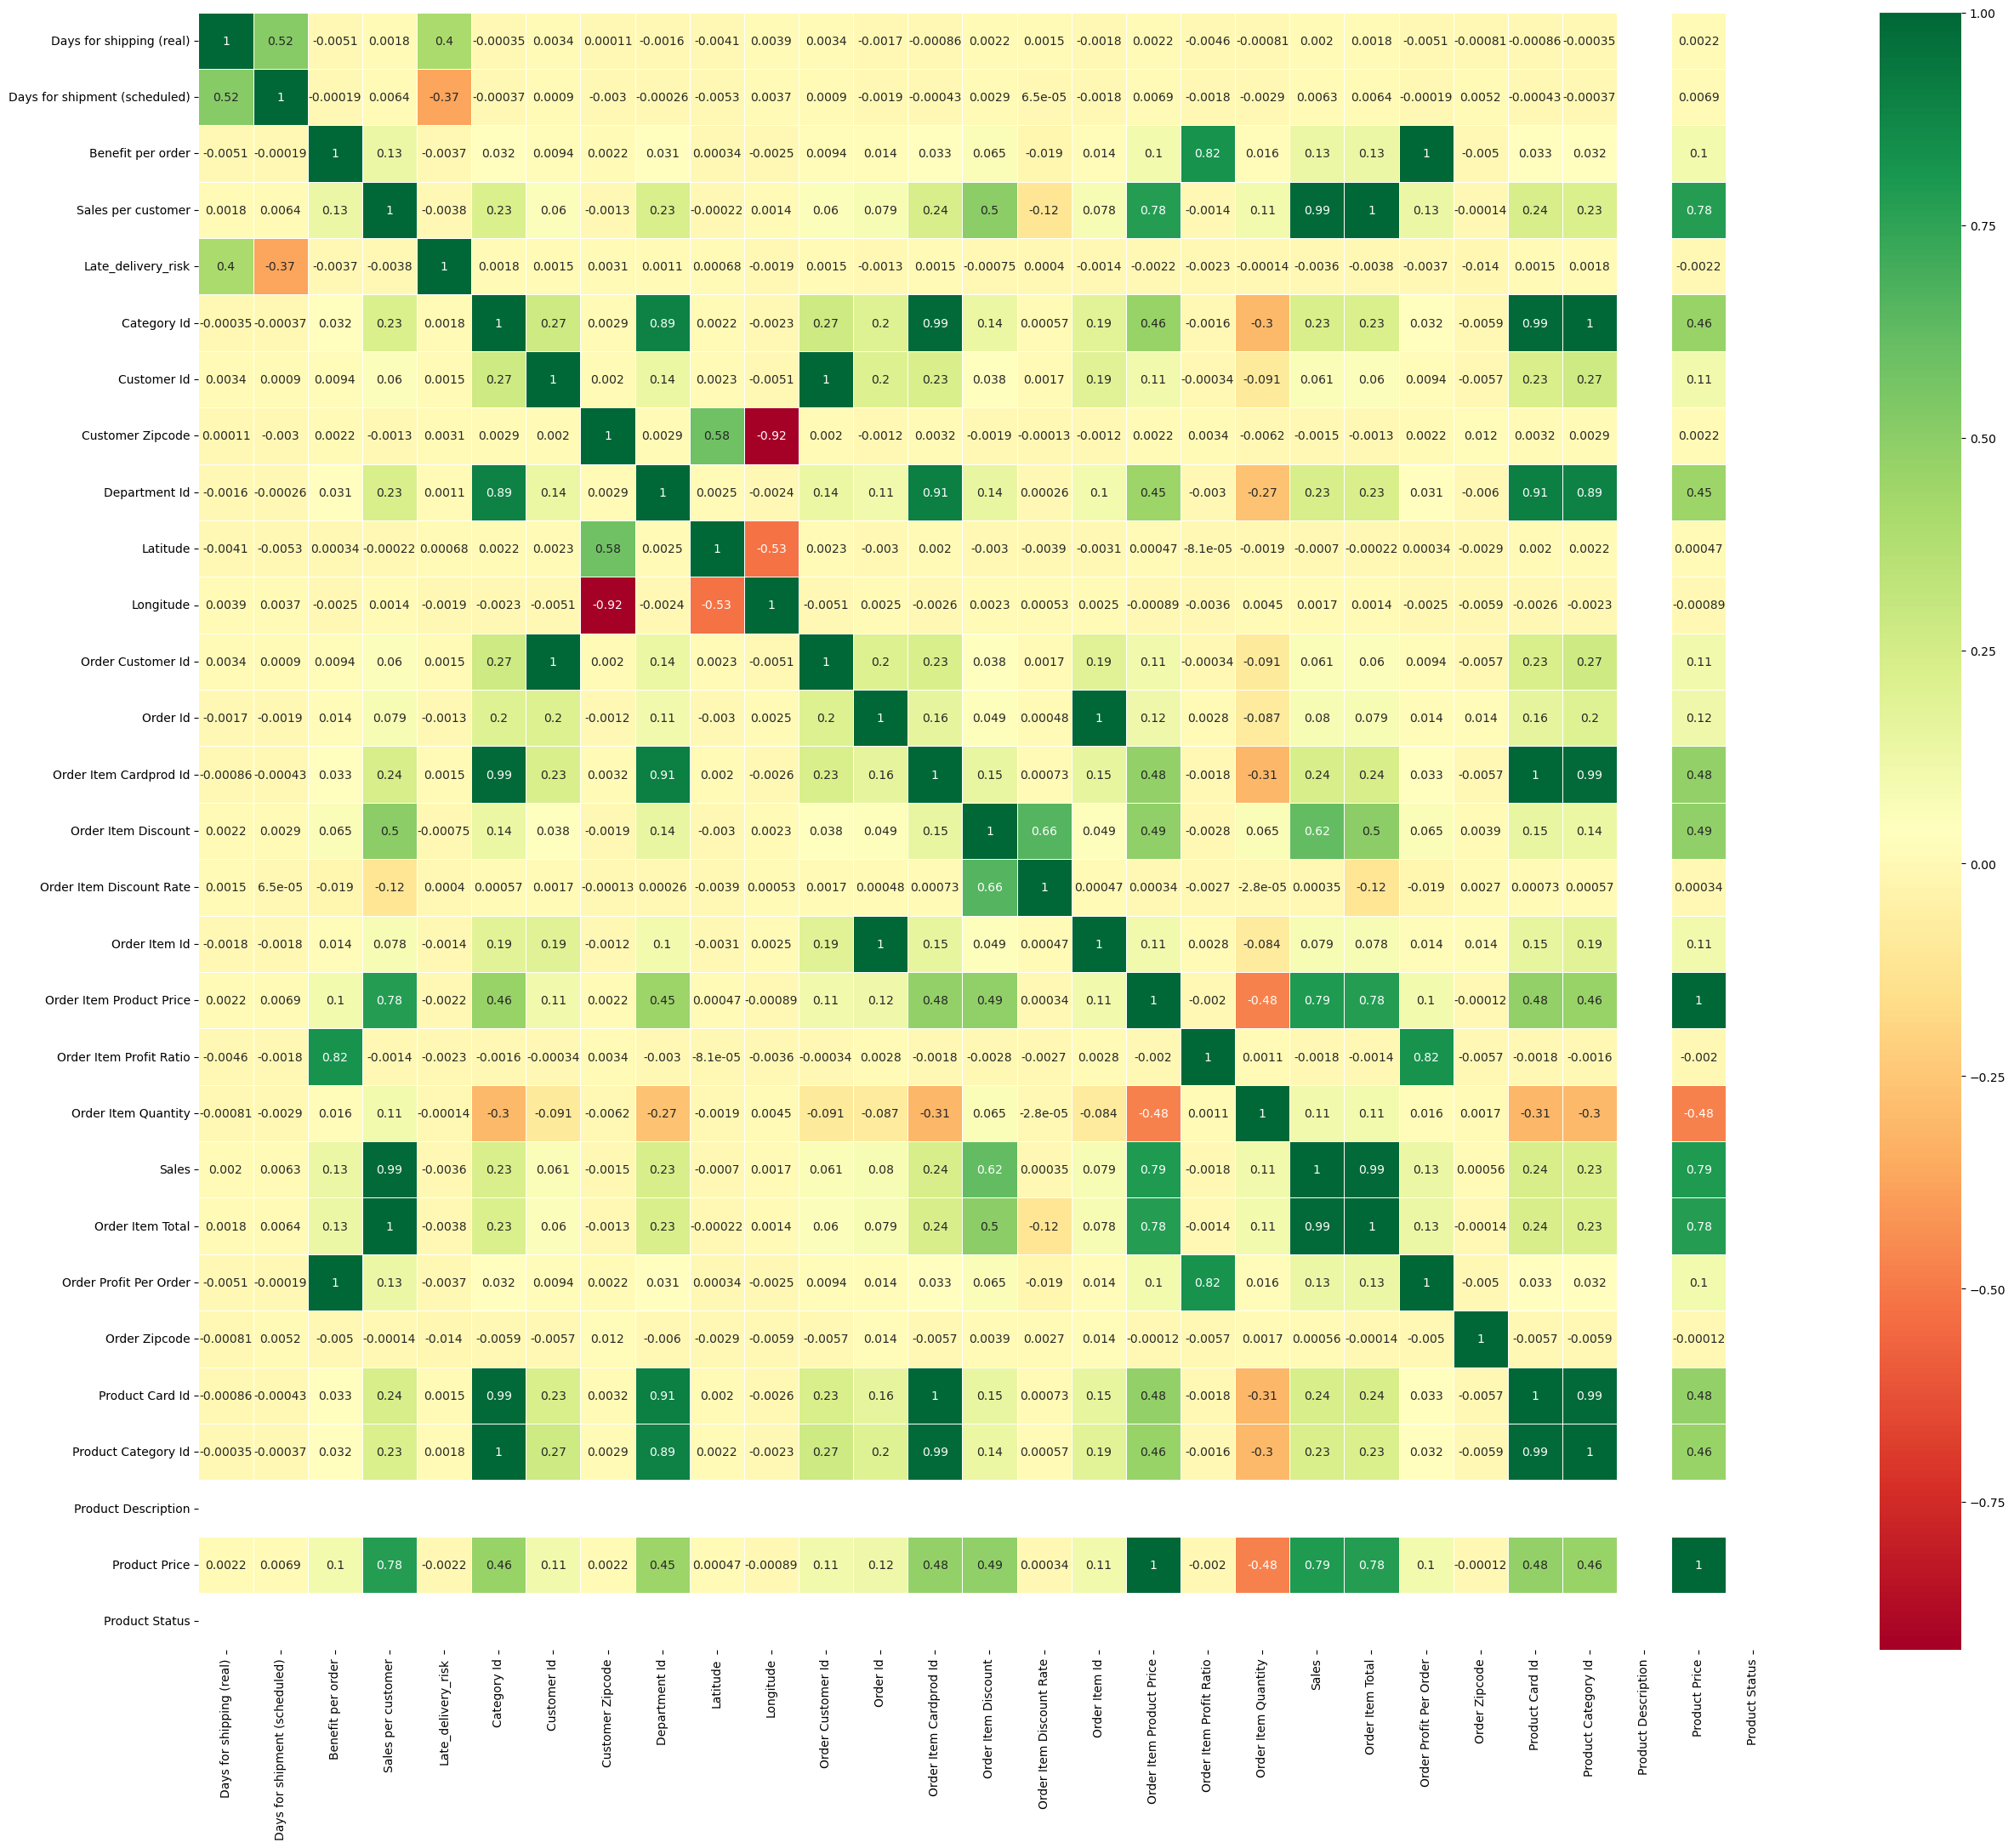

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Sales' is the target column and you want to exclude it from correlation
numeric_columns = data.select_dtypes(include=['number']).columns
numeric_data = data[numeric_columns]

# Create a correlation matrix
corrmap = numeric_data.corr()

# Select the top correlated features for better visualization
top_corr_features = corrmap.index

# Set a smaller figure size
plt.figure(figsize=(30, 25))

# Plot the heatmap
sns.heatmap(numeric_data[top_corr_features].corr(), annot=True, cmap="RdYlGn",linewidths=.5)

# Show the plot
plt.show()


In [75]:
#Converting categorical features that represent date and time to datetime datatype.
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])

# Handling Time and date variables
data['order_year'] = pd.DatetimeIndex(data['order_date']).year
data['order_month'] = pd.DatetimeIndex(data['order_date']).month
data['order_day'] = pd.DatetimeIndex(data['order_date']).day


In [76]:
# Prepare Data for LSTM
finance_features = ['Benefit per order', 'Sales per customer', 'Order Item Discount', 'Order Item Discount Rate',
                     'Order Item Product Price', 'Order Item Profit Ratio', 'order_year']
finance = data[finance_features]

# Assuming 'Sales' is the target column for forecasting
target_feature = 'Sales'
target_data = data[target_feature]

# Normalize data
scaler = StandardScaler()
finance_normalized = scaler.fit_transform(finance)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(finance_normalized, target_data, test_size=0.2, random_state=42)

# Build and Train LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



Epoch 1/50
4513/4513 [==============================] - 47s 9ms/step - loss: 29410.8379 - val_loss: 18028.9727
Epoch 2/50
4513/4513 [==============================] - 43s 9ms/step - loss: 12214.0439 - val_loss: 5323.4497
Epoch 3/50
4513/4513 [==============================] - 42s 9ms/step - loss: 4072.9136 - val_loss: 3060.5095
Epoch 4/50
4513/4513 [==============================] - 42s 9ms/step - loss: 2987.0947 - val_loss: 2526.5312
Epoch 5/50
4513/4513 [==============================] - 44s 10ms/step - loss: 2577.1758 - val_loss: 2231.9119
Epoch 6/50
4513/4513 [==============================] - 44s 10ms/step - loss: 2256.4780 - val_loss: 1954.9062
Epoch 7/50
4513/4513 [==============================] - 43s 10ms/step - loss: 1964.5337 - val_loss: 1715.8639
Epoch 8/50
4513/4513 [==============================] - 44s 10ms/step - loss: 1700.9419 - val_loss: 1472.2428
Epoch 9/50
4513/4513 [==============================] - 44s 10ms/step - loss: 1454.7412 - val_loss: 1255.9680
Epoch 10/50

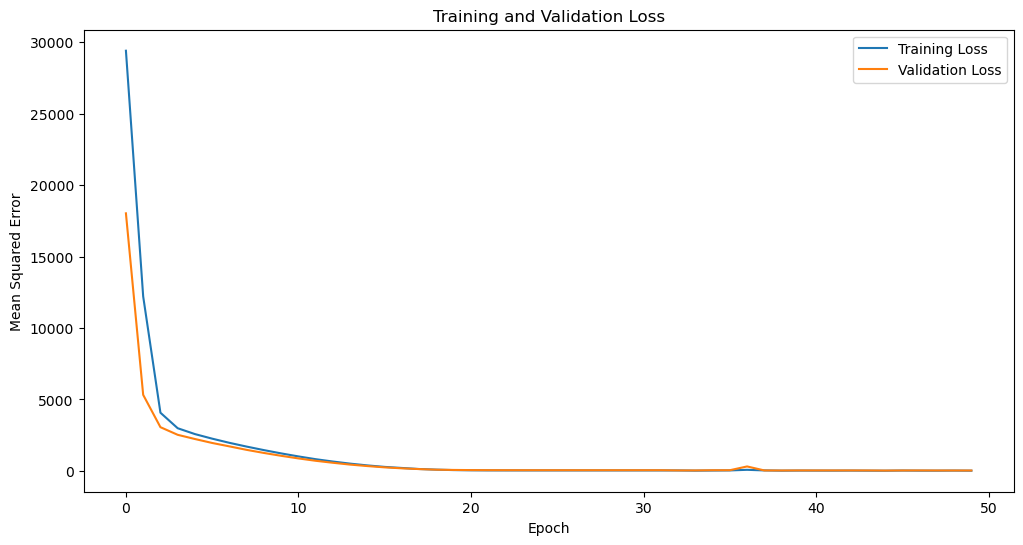

1129/1129 [==============================] - 4s 3ms/step


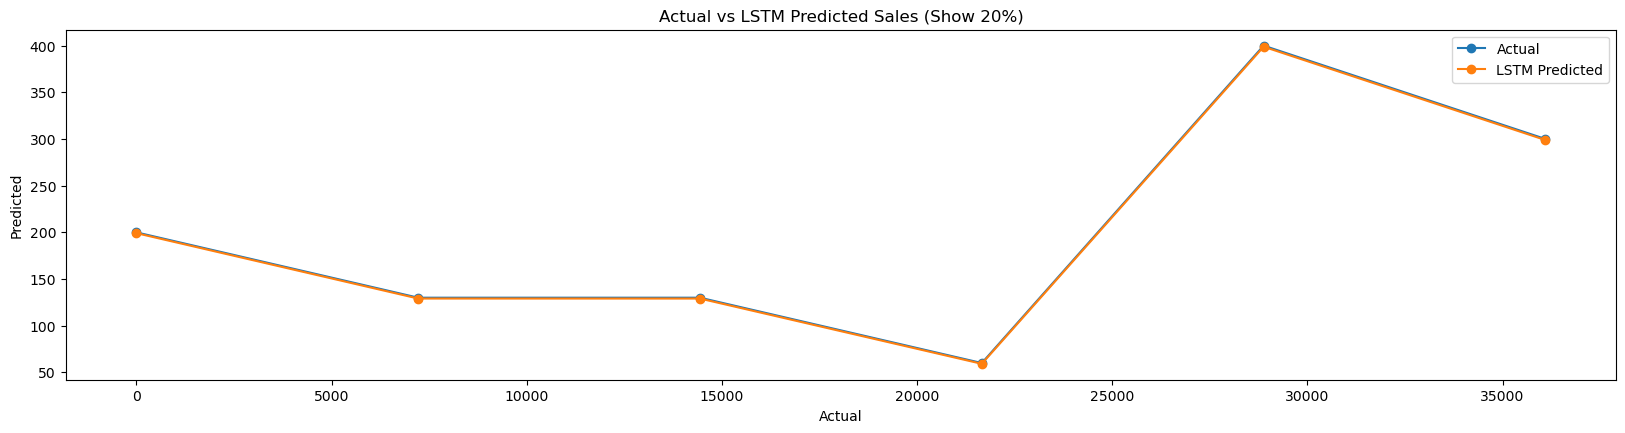

Mean Squared Error: 28.20045980854702
R2 Score: 0.998373764996998


In [77]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Make predictions
y_pred = model.predict(X_test)

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
sample_indices = range(0, len(y_test), int(len(y_test) * 0.2))
plt.plot(sample_indices, y_test.values[sample_indices], label='Actual', marker='o')
plt.plot(sample_indices, y_pred[sample_indices], label='LSTM Predicted', marker='o')
plt.title('Actual vs LSTM Predicted Sales (Show 20%)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

# Evaluate the model
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))


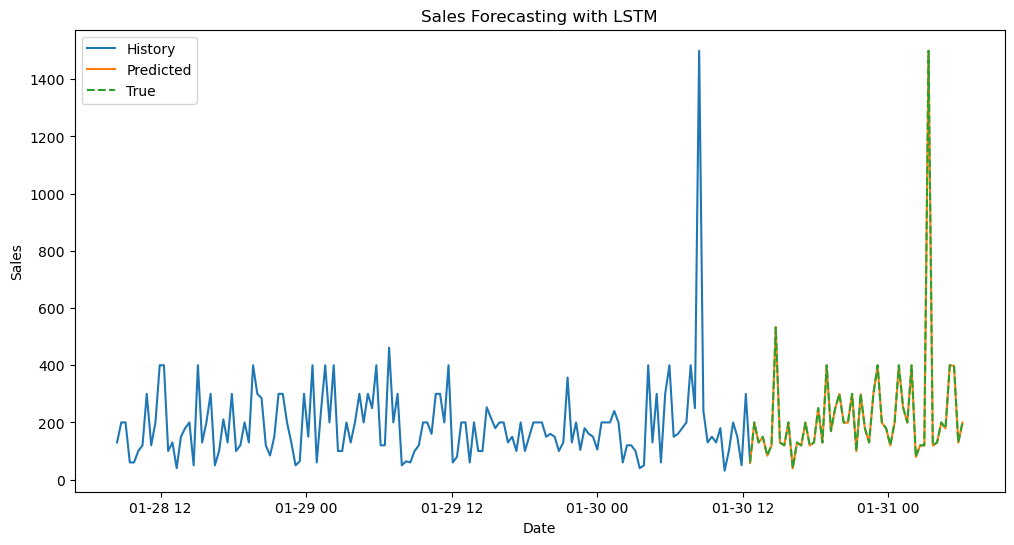

In [78]:
# Convert 'order date (DateOrders)' to datetime type
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])

# Sort the data by date
data_sorted = data.sort_values('order_date')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_sorted['order_date'][-250:-100], y_test[-250:-100], label='History')
plt.plot(data_sorted['order_date'][-101:-50], y_pred[-101:-50], label='Predicted')
plt.plot(data_sorted['order_date'][-101:-50], y_test[-101:-50], label='True', linestyle='--')

plt.title('Sales Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
